In [2]:
%load_ext tuna

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import numpy as np
import dill
import os
import seaborn as sns
import torch
import pandas as pd

from collections import namedtuple
from hmmlearn.hmm import MultinomialHMM
from scipy.special import logsumexp
from scipy.stats import multivariate_normal
from spn.algorithms.Inference import log_likelihood

from engine_dataset import generate_engine_dataset, generate_engine_datasets

from oSLRAU_run import get_data
from spn.structure.leaves.parametric.Parametric import Gaussian, Bernoulli, Categorical,  In_Latent, Multivariate_Gaussian
from spn.structure.Base import Context
from spn.algorithms.LearningWrappers import learn_parametric
from spn.io.Graphics import plot_spn
import numpy as np
from spn.algorithms.Inference import log_likelihood
from sklearn.model_selection import train_test_split
from spn.algorithms.oSLRAU import oSLRAU, oSLRAUParams
from spn.algorithms.RSPN import RSPN
from spn.algorithms.TransformStructure import Prune ,Prune_oSLRAU

from hmmlearn import hmm
from spn.algorithms.Inference import log_likelihood



from experiment_utils.datasets.vasopressors_dataset import load_vasopressors_dataset

The tuna extension is already loaded. To reload it, use:
  %reload_ext tuna


In [3]:
SEQ_LENGTH = 6
NUM_STATES = 20
NUM_SEEDS = 5
SEEDS = range(42, 42 + NUM_SEEDS)

train_vaso_datasets, test_vaso_datasets = load_vasopressors_dataset(
    seq_length=SEQ_LENGTH,
)
num_inputs = (
    int(
        np.max(train_vaso_datasets[0].inputs_raw)
    )
    + 1
)
num_observations = (
    int(
        np.max(train_vaso_datasets[0].observations_raw_discrete)
    )
    + 1
)

  0%|          | 0/6052 [00:00<?, ?it/s]

Loaded 5990 data points
Partitioning into folds...
Done!


In [173]:
# unique values in the observations_raw_discrete
# train_ds_0 = train_vaso_datasets[0]

# n=0
# for row in train_ds_0.inputs_raw:
#     if 1 in row:
#         print(row)
#         n+=1

# print(n)



[0 0 0 0 1 1]
[0 0 0 0 1 1]
[0 1 1 1 1 1]
[0 0 0 0 0 1]
[0 0 0 1 1 1]
[0 0 1 1 1 1]
[0 0 0 0 1 1]
[0 0 0 0 1 1]
[0 1 1 1 1 1]
[0 0 1 1 1 1]
[0 0 0 0 0 1]
[0 0 1 1 1 1]
[0 0 0 1 1 1]
[0 0 0 1 1 0]
[0 0 0 0 0 1]
[0 1 1 1 1 1]
[0 0 0 0 0 1]
[0 1 0 1 1 1]
[0 0 0 0 0 1]
[0 0 1 1 1 1]
[0 1 1 1 1 1]
[0 0 0 0 0 1]
[0 1 1 1 1 1]
[0 0 1 1 1 1]
[0 0 0 0 0 1]
[0 0 1 0 0 0]
[0 1 1 1 1 1]
[0 0 0 0 1 0]
[0 0 0 0 1 1]
[0 1 1 1 1 1]
[0 0 0 1 1 1]
[0 0 0 1 1 1]
[0 0 1 0 0 0]
[0 0 0 1 1 1]
[0 0 0 1 1 1]
[0 0 0 0 1 0]
[0 0 0 1 1 1]
[0 0 0 0 1 1]
[0 0 0 1 1 1]
[0 0 0 0 0 1]
[0 1 1 1 1 1]
[0 0 0 0 1 1]
[0 0 1 1 1 1]
[0 0 0 0 0 1]
[0 1 0 0 0 0]
[0 1 1 1 1 1]
[0 0 1 1 1 1]
[0 0 0 0 0 1]
[0 0 0 0 1 1]
[0 0 0 0 1 1]
[0 0 0 0 0 1]
[0 0 0 1 1 1]
[0 0 0 1 1 1]
[0 0 1 1 1 1]
[0 0 0 0 1 1]
[0 1 1 1 1 1]
[0 0 0 0 1 1]
[0 0 0 0 1 1]
[0 0 1 1 1 1]
[0 0 1 1 1 1]
[0 1 1 1 1 1]
[0 1 1 1 1 1]
[0 1 1 1 1 1]
[0 0 1 1 1 1]
[0 0 0 1 1 1]
[0 0 1 1 1 1]
[0 0 0 0 0 1]
[0 0 1 1 1 1]
[0 0 0 0 0 1]
[0 0 0 0 0 1]
[0 1 1 0 0 0]
[0 0 0

In [162]:
train_vaso_0 = train_vaso_datasets[0]

for i, s in enumerate(SEEDS):
    print(f"_______{s}______\n")
    ds = train_vaso_datasets[i]
    
    print(np.unique(ds.inputs_raw))

_______42______

[0 1]
_______43______

[0 1]
_______44______

[0 1]
_______45______

[0 1]
_______46______

[0 1]


In [5]:
print(train_vaso_0.observations_raw_discrete.shape)
print(train_vaso_0.inputs_raw.shape)

(4792, 6)
(4792, 6)


In [51]:
def train_rspn_vaso(train_data, test_data, epoch, rspn=None, os_args=None, do_updates=True):

    if len(train_data.shape) == 3: train_data = np.squeeze(train_data)
    if len(test_data.shape) == 3: test_data = np.squeeze(test_data)

    if rspn is None:
    
        rspn = RSPN(num_variables=os_args["num_variables"], num_latent_variables=os_args["num_latent_variables"], num_latent_values=os_args["num_latent_values"])
        first_mini_batch = train_data[0:os_args["mini_batch_size"]]
        n = first_mini_batch.shape[1]

        print(f"n: {n}") # = num_time_steps_mix * n_dim
        
        context = [Categorical, Bernoulli]*(int(n/2)) # Bernoulli Categorical
        ds_context = Context(parametric_types=context).add_domains(first_mini_batch[:, :os_args["num_variables"]])
        spn, initial_template_spn, top_spn = rspn.build_initial_template(first_mini_batch, ds_context, os_args["len_sequence_varies"])

    
    no_of_minibatches = int(train_data.shape[0] / os_args["mini_batch_size"])

    print(f"no of minibatches: {no_of_minibatches}")

    
    for i in range(1, no_of_minibatches):
        mini_batch = train_data[i * os_args["mini_batch_size"]: (i+1) * os_args["mini_batch_size"]]
    
        update_template = False
        
        if i==10 and epoch == 0 and do_updates: #and epoch == 0:
            update_template = True

        
    
        template_spn = rspn.learn_rspn(mini_batch, update_template, os_args["os_params"], os_args["unroll"],
                                                os_args["full_update"], os_args["update_leaves"],
                                                os_args["len_sequence_varies"])
           
            
    test_ll = np.sum(rspn.log_likelihood(test_data, os_args["unroll"], os_args["len_sequence_varies"]))


    return test_ll, rspn, template_spn

In [52]:
def final_ll_vaso(data, num_epochs=1, do_plot_spn=True, os_args=None, split_data=False,rspn=None, do_updates=True):
    ll = -np.inf
    if split_data:
        train_data, val_data= train_test_split(data, test_size=0.1, random_state=42)
    
    else:
        train_data, val_data = data, data
    for epoch in range(num_epochs):
        print(train_data.shape)
        
        
        epoch_ll, rspn, template_spn = train_rspn_vaso(train_data, val_data, epoch, rspn, os_args, do_updates)        
        print(f"epoch_ll: {epoch_ll}")
        
        ll = epoch_ll

    print(f" \n\n\n final ll: {ll}\n\n\n")

    if do_plot_spn:
        plot_spn(template_spn, 'rspn_final_template.pdf')
    
    return rspn, template_spn

In [53]:
def process_ds(ds):
    raw_inputs = ds.inputs_raw
    obs_raw_cont = ds.observations_raw_discrete


    comb_ds = []
    ones_ds = []
    for i in range(raw_inputs.shape[0]):
        comb_ds_i = []
        for j in range(raw_inputs.shape[1]):
             comb_ds_j = [obs_raw_cont[i, j], raw_inputs[i,j]]
             comb_ds_i.append(comb_ds_j)


        comb_ds.append(comb_ds_i)

    comb_ds = np.array(comb_ds)
    comb_ds = comb_ds.reshape(raw_inputs.shape[0], -1)

    for row in comb_ds:
        if 1 in row:
            ones_ds.append(row)
    
    ones_ds = np.array(ones_ds)
    return comb_ds, ones_ds

In [54]:
n_states = 2
n_dim = 2

num_time_steps = 6

# oSLRAU_params = oSLRAUParams(mergebatch_threshold=128, corrthresh=0.1, mvmaxscope=1, equalweight=True, currVals=True)
oSLRAU_params = oSLRAUParams(mergebatch_threshold=100, corrthresh=0.7, mvmaxscope=1, equalweight=True, currVals=True)

os_args = {
    "num_variables": num_time_steps * n_dim,
    "num_latent_variables" : 2,
    "num_latent_values" : 2,
    "unroll" : "backward",
    "full_update" : False,
    "update_leaves" : True,
    "len_sequence_varies" : False,
    "mini_batch_size" : 5,
    "update_after_no_min_batches" : 10,
    "do_updates" : False,
    "os_params": oSLRAU_params
    }

In [55]:
log_likelihoods = []
rspn_vaso_models = []

In [56]:
base_seed = SEEDS[0]
seed_dict = {SEEDS[i]: i for i in range(len(SEEDS))}
seed_ls = SEEDS # [SEEDS[1]]



for seed in seed_ls:
    i = seed_dict[seed]
    print(f"——————————[ Running experiment for seed {seed} ]——————————")
    train_ds, train_all_ones = process_ds(train_vaso_datasets[i])
    test_ds, _ = process_ds(test_vaso_datasets[i])
    
    rspn_vaso, template_spn = final_ll_vaso(train_ds, num_epochs=3, do_plot_spn=False, os_args=os_args, rspn=None)
    # rspn_vaso = final_ll_vaso(train_all_ones, num_epochs=3, do_plot_spn=False, os_args=os_args, rspn=None, do_updates=True)
    rspn_test_ll_mimic = np.sum(rspn_vaso.log_likelihood(test_ds, os_args["unroll"], os_args["len_sequence_varies"]))
    print(f"seed {seed}: log likelihood: {rspn_test_ll_mimic}")
    log_likelihoods.append(rspn_test_ll_mimic)
    rspn_vaso_models.append(rspn_vaso)
    break

——————————[ Running experiment for seed 42 ]——————————
(4792, 12)
n: 12
==>> data.shape: (5, 12)
len(self.meta_types): 12
self.meta_types.values(): dict_values([<MetaType.REAL: 1>, <MetaType.REAL: 1>, <MetaType.REAL: 1>, <MetaType.REAL: 1>, <MetaType.REAL: 1>, <MetaType.REAL: 1>, <MetaType.REAL: 1>, <MetaType.REAL: 1>, <MetaType.REAL: 1>, <MetaType.REAL: 1>, <MetaType.REAL: 1>, <MetaType.REAL: 1>])
len(self.meta_types.values()): 12
data[:, col]: [4 0 4 0 6]
==>> domain_values: [0, 6]
feature_meta_type: MetaType.REAL
==>> domain_values: [0, 6]
len(self.meta_types.values()): 12
data[:, col]: [0 0 0 0 0]
==>> domain_values: [0, 0]
feature_meta_type: MetaType.REAL
==>> domain_values: [0, 0]
len(self.meta_types.values()): 12
data[:, col]: [4 0 4 0 6]
==>> domain_values: [0, 6]
feature_meta_type: MetaType.REAL
==>> domain_values: [0, 6]
len(self.meta_types.values()): 12
data[:, col]: [0 0 0 0 0]
==>> domain_values: [0, 0]
feature_meta_type: MetaType.REAL
==>> domain_values: [0, 0]
len(self.m

/Users/dariyankhan/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Work (one drive)/Imperial/MIT/exchange_year/summer-UROP-knowledge-distillation/policy_stuff/policy-learn/SPFlow/src/spn/algorithms/oSLRAU.py:76: RuntimeWarning: divide by zero encountered in log
  w_children_log_probs[:, i] = lls_per_node[parent_result, c.id] + np.log(node.weights[i])


==>> in_latent_dict: {In_LatentNode_1: array([0, 1, 2, 3, 4])}
==>> in_latent_dict: {In_LatentNode_1: array([0, 1, 2, 3, 4])}
==>> in_latent_dict: {In_LatentNode_1: array([0, 1, 2, 3, 4])}
==>> in_latent_dict: {In_LatentNode_1: array([0, 1, 2, 3, 4])}
==>> in_latent_dict: {In_LatentNode_1: array([0, 1, 2, 3, 4])}
==>> in_latent_dict: {In_LatentNode_1: array([0, 1, 2, 3, 4])}
==>> in_latent_dict: {In_LatentNode_1: array([0, 1, 2, 3, 4])}
==>> in_latent_dict: {In_LatentNode_1: array([0, 1, 2, 3, 4])}
==>> in_latent_dict: {In_LatentNode_1: array([0, 1, 2, 3, 4])}
==>> in_latent_dict: {In_LatentNode_1: array([0, 1, 2, 3, 4])}
==>> in_latent_dict: {In_LatentNode_1: array([0, 1, 2, 3, 4])}
==>> in_latent_dict: {In_LatentNode_1: array([0, 1, 2, 3, 4])}
==>> in_latent_dict: {In_LatentNode_1: array([0, 1, 2, 3, 4])}
==>> in_latent_dict: {In_LatentNode_1: array([0, 1, 2, 3, 4])}
==>> in_latent_dict: {In_LatentNode_1: array([0, 1, 2, 3, 4])}
==>> in_latent_dict: {In_LatentNode_1: array([0, 1, 2, 

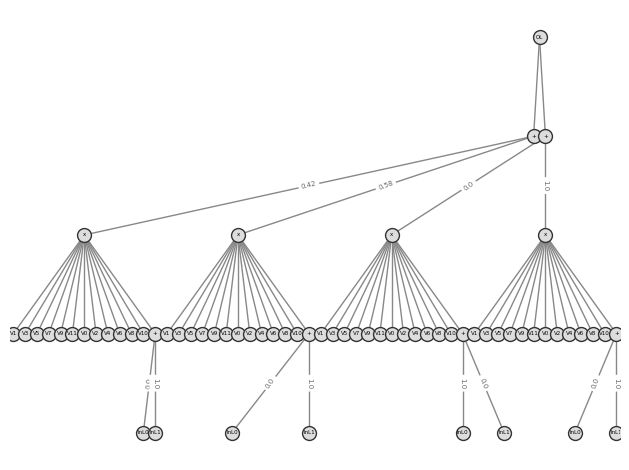

In [57]:
plot_spn(template_spn, 'rspn_final_template.pdf')

In [47]:
# print(f"Mean: {np.array(log_likelihoods).mean()}")
# print(f"STD: {np.array(log_likelihoods).std()}")

Mean: -14290.806510859877
STD: 1144.699024595064


In [197]:
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")

Mean: -18062.228323318934
STD: 1488.367852715393


In [208]:
import pickle

test_ds_list = []
for ds in test_vaso_datasets:
    curr_ds, _ = process_ds(ds)
    test_ds_list.append(curr_ds)


with open('all_vaso_vars.pickle', 'wb') as file:
     pickle.dump(rspn_vaso_models[-5:], file)  # Store variable 'a' rspn_mimic_models
     pickle.dump(test_ds_list, file) 

In [195]:
# import pickle
# with open('all_vaso_vars.pickle', 'rb') as file:  
#     rspn_vaso_models = pickle.load(file)  
#     test_ds_list_old = pickle.load(file)

# NUM_SEEDS = 5
# SEEDS = range(42, 42 + NUM_SEEDS)

# len(rspn_vaso_models), len(test_ds_list_old)

(5, 5)

In [170]:
for ds in train_vaso_datasets:
    print(np.unique(ds.inputs_raw, return_counts=True))

(array([0, 1]), array([27221,  1531]))
(array([0, 1]), array([27269,  1483]))
(array([0, 1]), array([27312,  1440]))
(array([0, 1]), array([27321,  1431]))
(array([0, 1]), array([27805,   947]))


In [222]:
%%capture
from spn.algorithms.Marginalization import marginalize
from copy import deepcopy
from spn.algorithms.MPE import mpe
from spn.structure.Base import assign_ids, rebuild_scopes_bottom_up
from spn.io.Text import str_to_spn, spn_to_str_equation
from sklearn.metrics import mean_squared_error as sk_mse, f1_score, roc_auc_score, brier_score_loss


num_time_steps = 6
n_dim = 2


def next_error(model, data, num_time_steps=num_time_steps, num_dims=n_dim):
    unrolled_model = model.get_unrolled_rspn(model.get_len_sequence())
    preds_arr = np.zeros((data.shape[0], (num_time_steps)*(n_dim-1))) # assuming 1 control variable

    preds_arr[:,0] = data[:, 1]

    p = 1 #index to insert for preds array
    # for k, t in enumerate(range(3, num_time_steps*n_dim+1, 4)):
    for action in range(3, num_time_steps*n_dim+1, 2):


        vars_to_include = list(range(action-1)) + [action]
        spn_marg = marginalize(unrolled_model, vars_to_include)
        
        data_t = deepcopy(data)
        data_t[:, action] = np.nan
        data_t = data_t[:, :action+1]
        print(f"data_t: {data_t}")
       
        spn_mpe = mpe(spn_marg, data_t)
        curr_spn_mpe = spn_mpe[:, action]
        

        preds_arr[:, p] = curr_spn_mpe
        p += 1
    return preds_arr



def metric_over_all_vars(models, test_ds_list, metric_func):
    all_metric_vars = []
    for i, (model, test_ds) in enumerate(zip(models, test_ds_list)):
        print(test_ds)
        test_ds = test_ds.astype(float)
        print(f"seed:__________{SEEDS[i]}___________")
        pred_arr = next_error(model, test_ds)
        print(np.unique(pred_arr))
        assert False
        rmse_vars = metric_func(pred_arr, test_ds)
        all_metric_vars.append(rmse_vars)
    return all_metric_vars
  

In [223]:
def rmse_over_vars(preds, real_data):
    rmses = []
    n_dim=2
    real_actions_sl = real_data[:, 1::2]
    rmse_action = sk_mse(preds.flatten(), real_actions_sl.flatten(),multioutput="raw_values", squared=False)
    rmses.append(rmse_action)
    
    return rmses

def f1_over_vars(preds, real_data):
    f1s = []
    n_dim=2
    real_actions_sl = real_data[:, 1::2]
    f1_action = f1_score(preds.flatten(), real_actions_sl.flatten())
    f1s.append(f1_action)
    
    return f1_action

def roc_auc_over_vars(preds, real_data):
    n_dim=2
    real_actions_sl = real_data[:, 1::2]
    # print(f"real_actions_sl counts: {np.unique(real_actions_sl, return_counts=True)}")

    try:
        roc_auc_action = roc_auc_score(real_actions_sl.flatten(), preds.flatten())
    
    except ValueError:
        roc_auc_action = np.nan

    return roc_auc_action


def brier_over_vars(preds, real_data):
    n_dim=2
    real_actions_sl = real_data[:, 1::2]
    brier_action = brier_score_loss(preds.flatten(), real_actions_sl.flatten())
    return brier_action

In [224]:
all_f1_vars = metric_over_all_vars(rspn_vaso_models, test_ds_list, f1_over_vars)
all_roc_auc_vars = metric_over_all_vars(rspn_vaso_models, test_ds_list, roc_auc_over_vars)
all_brier_vars = metric_over_all_vars(rspn_vaso_models, test_ds_list, brier_over_vars)

[[9 0 9 ... 0 9 0]
 [0 0 0 ... 0 4 0]
 [4 0 4 ... 0 0 0]
 ...
 [4 0 0 ... 0 0 0]
 [0 0 0 ... 0 4 0]
 [4 0 4 ... 0 0 0]]
seed:__________42___________
==>> child: In_LatentNode_1
==>> child: In_LatentNode_2
==>> child: In_LatentNode_59
==>> child: In_LatentNode_60
==>> child: In_LatentNode_61
==>> child: In_LatentNode_62
==>> child: In_LatentNode_63
==>> child: In_LatentNode_64
==>> child: In_LatentNode_65
==>> child: In_LatentNode_66
data_t: [[ 9.  0.  9. nan]
 [ 0.  0.  0. nan]
 [ 4.  0.  4. nan]
 ...
 [ 4.  0.  0. nan]
 [ 0.  0.  0. nan]
 [ 4.  0.  4. nan]]
data_t: [[ 9.  0.  9.  0.  9. nan]
 [ 0.  0.  0.  0.  4. nan]
 [ 4.  0.  4.  0.  4. nan]
 ...
 [ 4.  0.  0.  0.  8. nan]
 [ 0.  0.  0.  0.  0. nan]
 [ 4.  0.  4.  0.  4. nan]]
data_t: [[ 9.  0.  9. ...  0.  9. nan]
 [ 0.  0.  0. ...  0.  0. nan]
 [ 4.  0.  4. ...  0.  8. nan]
 ...
 [ 4.  0.  0. ...  0.  8. nan]
 [ 0.  0.  0. ...  0.  4. nan]
 [ 4.  0.  4. ...  0.  0. nan]]
data_t: [[ 9.  0.  9. ...  0.  9. nan]
 [ 0.  0.  0. ...  0

AssertionError: 

In [221]:
metric_names = ["f1", "roc_auc", "brier"]
metric_lists = [all_f1_vars, all_roc_auc_vars, all_brier_vars]

for name, ls in zip(metric_names, metric_lists):

    print(f"_____{name}_____")
    print(f"overall mean across the 5 seeds: {np.nanmean(ls)}")
    print(f"overall sd across the 5 seeds: {np.nanstd(ls)}")
    print(f"full array for each seed:{ls}\n\n")

_____f1_____
overall mean across the 5 seeds: 0.0
overall sd across the 5 seeds: 0.0
full array for each seed:[0.0, 0.0, 0.0, 0.0, 0.0]


_____roc_auc_____
overall mean across the 5 seeds: 0.5
overall sd across the 5 seeds: 0.0
full array for each seed:[0.5, 0.5, 0.5, 0.5, 0.5]


_____brier_____
overall mean across the 5 seeds: 0.04752365052865888
overall sd across the 5 seeds: 0.029588940934614363
full array for each seed:[0.024624373956594323, 0.031302170283806344, 0.03728436282693378, 0.038536449638286036, 0.1058708959376739]


